#**1.Introdução**

Neste projeto, utilizamos técnicas de ciência de dados para prever a probabilidade de inadimplência de clientes com base em seu histórico de crédito. O objetivo é auxiliar empresas na identificação de perfis de maior risco, permitindo uma gestão mais eficiente da concessão de crédito e redução de perdas financeiras.

Etapas:

- Coleta e Pré-processamento de Dados

- Análise Exploratória de Dados

- Desenvolvimento do Modelo (Regressão Logística)

- Avaliação e Interpretação dos Resultados

- Ponto ótimo entre prever inadimplencia X Recusar bons Pagadores

#**2. Importando Bibliotecas**


In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import urllib.request
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

#**3. Analisando estrutura do dataset**

In [156]:
url = "https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip"
zip_path = "default_credit.zip"

# Baixar o arquivo
urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dados_credito")

df = pd.read_excel("dados_credito/default of credit card clients.xls", header=1)

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [158]:
df.rename(columns={
    "LIMIT_BAL": "limite",
    "SEX": "sexo",
    "EDUCATION": "escolaridade",
    "MARRIAGE": "estado_civil",
    "AGE": "idade",
    "PAY_0": "st_pag_set",
    "PAY_2": "st_pag_ago",
    "PAY_3": "st_pag_jul",
    "PAY_4": "st_pag_jun",
    "PAY_5": "st_pag_mai",
    "PAY_6": "st_pag_abr",
    "BILL_AMT1": "vlr_fat_set",
    "BILL_AMT2": "vlr_fat_ago",
    "BILL_AMT3": "vlr_fat_jul",
    "BILL_AMT4": "vlr_fat_jun",
    "BILL_AMT5": "vlr_fat_mai",
    "BILL_AMT6": "vlr_fat_abr",
    "PAY_AMT1": "vlr_pago_set",
    "PAY_AMT2": "vlr_pago_ago",
    "PAY_AMT3": "vlr_pago_jul",
    "PAY_AMT4": "vlr_pago_jun",
    "PAY_AMT5": "vlr_pago_mai",
    "PAY_AMT6": "vlr_pago_abr",
    "default payment next month": "target"
}, inplace=True)

In [159]:
df = df.drop('ID', axis=1)
df

,limite,sexo,escolaridade,estado_civil,idade,st_pag_set,st_pag_ago,st_pag_jul,st_pag_jun,st_pag_mai,...,vlr_fat_jun,vlr_fat_mai,vlr_fat_abr,vlr_pago_set,vlr_pago_ago,vlr_pago_jul,vlr_pago_jun,vlr_pago_mai,vlr_pago_abr,target
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


**Glossário das Variáveis**

| Variável       | Descrição                                                                                          |
|----------------|--------------------------------------------------------------------------------------------------|
| **id**         | Identificador único do cliente                                                                    |
| **limite**     | Limite total de crédito concedido ao cliente (NT dollars)                                         |
| **sexo**       | Sexo do cliente: <br>1 = masculino; 2 = feminino                                                  |
| **escolaridade** | Nível educacional do cliente: <br>1 = pós-graduação; 2 = graduação; 3 = ensino médio; 4 = outros |
| **estado_civil** | Estado civil do cliente: <br>1 = casado; 2 = solteiro; 3 = outros                                |
| **idade**      | Idade do cliente em anos                                                                          |
| **st_pag_set** | Situação do pagamento em setembro de 2005: <br>-1 = pagou em dia; 1 = atraso 1 mês; 2 = atraso 2 meses; ...; 9 = atraso >= 9 meses |
| **st_pag_ago** | Situação do pagamento em agosto de 2005 (mesma escala que acima)                                  |
| **st_pag_jul** | Situação do pagamento em julho de 2005                                                          |
| **st_pag_jun** | Situação do pagamento em junho de 2005                                                          |
| **st_pag_mai** | Situação do pagamento em maio de 2005                                                           |
| **st_pag_abr** | Situação do pagamento em abril de 2005                                                          |
| **vlr_fat_set**| Valor da fatura gerada em setembro de 2005 (NT dollars)                                          |
| **vlr_fat_ago**| Valor da fatura gerada em agosto de 2005                                                        |
| **vlr_fat_jul**| Valor da fatura gerada em julho de 2005                                                         |
| **vlr_fat_jun**| Valor da fatura gerada em junho de 2005                                                         |
| **vlr_fat_mai**| Valor da fatura gerada em maio de 2005                                                          |
| **vlr_fat_abr**| Valor da fatura gerada em abril de 2005                                                         |
| **vlr_pago_set**| Valor pago pelo cliente em setembro de 2005 (NT dollars)                                         |
| **vlr_pago_ago**| Valor pago em agosto de 2005                                                                     |
| **vlr_pago_jul**| Valor pago em julho de 2005                                                                      |
| **vlr_pago_jun**| Valor pago em junho de 2005                                                                      |
| **vlr_pago_mai**| Valor pago em maio de 2005                                                                       |
| **vlr_pago_abr**| Valor pago em abril de 2005                                                                      |
| **target**     | Variável alvo: inadimplência no próximo mês <br> 1 = inadimplente; 0 = não inadimplente           |


#**4. Pré-processamento dos dados**

In [160]:
# Variáveis categóricas
cat_vars = ['sexo', 'escolaridade', 'estado_civil',
            'st_pag_set', 'st_pag_ago', 'st_pag_jul', 'st_pag_jun', 'st_pag_mai', 'st_pag_abr',
            'target']

for col in cat_vars:
    df[col] = df[col].astype('category')

print(df.dtypes)

limite             int64
sexo            category
escolaridade    category
estado_civil    category
idade              int64
st_pag_set      category
st_pag_ago      category
st_pag_jul      category
st_pag_jun      category
st_pag_mai      category
st_pag_abr      category
vlr_fat_set        int64
vlr_fat_ago        int64
vlr_fat_jul        int64
vlr_fat_jun        int64
vlr_fat_mai        int64
vlr_fat_abr        int64
vlr_pago_set       int64
vlr_pago_ago       int64
vlr_pago_jul       int64
vlr_pago_jun       int64
vlr_pago_mai       int64
vlr_pago_abr       int64
target          category
dtype: object


Notas:

Converti as variáveis para o tipo categórico porque representam grupos distintos, não valores numéricos contínuos. Isso evita interpretações erradas pelo modelo e otimiza a manipulação dos dados.

In [161]:
df.isnull().sum()

,0
limite,0
sexo,0
escolaridade,0
estado_civil,0
idade,0
st_pag_set,0
st_pag_ago,0
st_pag_jul,0
st_pag_jun,0
st_pag_mai,0


Notas:

Não há valores faltantes a base.

In [162]:
df['estado_civil'].unique()

[1, 2, 3, 0]
Categories (4, int64): [0, 1, 2, 3]

In [163]:
total = len(df)
contagem = df['estado_civil'].value_counts().sort_index()
percentual = (contagem / total * 100).round(2)

resumo = pd.DataFrame({
    'Quantidade': contagem,
    'Percentual (%)': percentual
})

print(resumo)

              Quantidade  Percentual (%)
estado_civil                            
0                     54            0.18
1                  13659           45.53
2                  15964           53.21
3                    323            1.08


Notas:

**Decisão de agrupar o código 0 com o 3 na variável estado_civil:**

O código 0 representa uma categoria muito pouco frequente (apenas 54 registros, cerca de 0,18% do total) e não possui definição clara na documentação da base. Por se tratar de uma quantidade insignificante do ponto de vista estatístico e por provavelmente representar um valor indefinido ou desconhecido, decidiu-se agrupar o 0 com o código 3, que já representa casos diversos (como divorciados, viúvos ou outros). Essa abordagem simplifica a análise sem comprometer a qualidade dos dados e mantém a consistência das categorias.

In [164]:
df['estado_civil'] = df['estado_civil'].replace({0: 3})
contagem = df['estado_civil'].value_counts()
percentual = (contagem / len(df) * 100).round(2)

resumo_estado_civil = pd.DataFrame({
    'Quantidade': contagem,
    'Percentual (%)': percentual
}).sort_index()

resumo_estado_civil

,Quantidade,Percentual (%)
estado_civil,,
1,13659,45.53
2,15964,53.21
3,377,1.26


In [165]:
st_cols = ['st_pag_set', 'st_pag_ago', 'st_pag_jul', 'st_pag_jun', 'st_pag_mai', 'st_pag_abr']

for col in st_cols:
    unique_vals = df[col].unique()
    print(f"Valores únicos da coluna {col}: {sorted(unique_vals)}\n")

Valores únicos da coluna st_pag_set: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_ago: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_jul: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_jun: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_mai: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_abr: [-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]



In [166]:
st_cols = ['st_pag_set', 'st_pag_ago', 'st_pag_jul', 'st_pag_jun', 'st_pag_mai', 'st_pag_abr']
total = len(df)

for col in st_cols:
    count_neg2 = (df[col] == -2).sum()
    percent_neg2 = (count_neg2 / total) * 100
    print(f"{col}: {count_neg2} ocorrências de -2 ({percent_neg2:.4f}%)")

st_pag_set: 2759 ocorrências de -2 (9.1967%)
st_pag_ago: 3782 ocorrências de -2 (12.6067%)
st_pag_jul: 4085 ocorrências de -2 (13.6167%)
st_pag_jun: 4348 ocorrências de -2 (14.4933%)
st_pag_mai: 4546 ocorrências de -2 (15.1533%)
st_pag_abr: 4895 ocorrências de -2 (16.3167%)


In [167]:
# Criar a coluna booleana
df['tem_neg2'] = df[st_cols].apply(lambda row: (row == -2).any(), axis=1)

# Contar e calcular percentual
contagem = df['tem_neg2'].value_counts()
percentual = (contagem / len(df) * 100).round(2)

# Criar DataFrame resumo
resumo = pd.DataFrame({
    'Quantidade': contagem,
    'Percentual (%)': percentual
})

# Renomear o índice para melhor leitura
resumo.index = ['Não tem -2', 'Tem -2']

print(resumo)

            Quantidade  Percentual (%)
Não tem -2       23439           78.13
Tem -2            6561           21.87


In [168]:
# taxa de inadimplência entre grupos
perfil_neg2 = df.groupby('tem_neg2')['target'].value_counts(normalize=True).unstack() * 100

perfil_neg2.index = ['Não tem -2', 'Tem -2']
perfil_neg2.columns = ['Sem default (0)', 'Default (1)']
perfil_neg2 = perfil_neg2.round(2)

print(perfil_neg2)

            Sem default (0)  Default (1)
Não tem -2            77.03        22.97
Tem -2                80.93        19.07


In [169]:
df = df.drop(columns=['tem_neg2'])

Notas:

**Decisão de agrupar a categoria -2 com -1:**

A categoria -2 representa casos de pagamento ainda mais adiantado do que a categoria -1, que já indica pagamento antecipado. Embora o valor -2 não esteja oficialmente documentado na base de dados, sua presença significativa e o comportamento semelhante de inadimplência entre os clientes com -2 e -1 indicam que ambos refletem um bom histórico de pagamento.

Para simplificar a modelagem e evitar a fragmentação de categorias raras, optou-se por agrupar -2 com -1, considerando-os ambos como pagamentos adiantados. Essa decisão mantém a coerência da escala ordinal e preserva a qualidade preditiva dos dados.

In [170]:
st_cols = ['st_pag_set', 'st_pag_ago', 'st_pag_jul', 'st_pag_jun', 'st_pag_mai', 'st_pag_abr']

# Substituir -2 por -1
df[st_cols] = df[st_cols].replace(-2, -1)
st_cols = ['st_pag_set', 'st_pag_ago', 'st_pag_jul', 'st_pag_jun', 'st_pag_mai', 'st_pag_abr']

for col in st_cols:
    unique_vals = df[col].unique()
    print(f"Valores únicos da coluna {col}: {sorted(unique_vals)}\n")


Valores únicos da coluna st_pag_set: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_ago: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_jul: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_jun: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_mai: [-1, 0, 2, 3, 4, 5, 6, 7, 8]

Valores únicos da coluna st_pag_abr: [-1, 0, 2, 3, 4, 5, 6, 7, 8]



In [171]:
df['sexo'].unique()

[2, 1]
Categories (2, int64): [1, 2]

In [172]:
df['sexo'] = df['sexo'].replace({1: 0, 2: 1})

Notas:

Substituí os valores 1 e 2 por 0 e 1, respectivamente, para representar a variável como binária. Isso facilita o processamento pelo modelo, que interpreta melhor variáveis codificadas em formato 0/1.

In [173]:
df['escolaridade'].unique()

[2, 1, 3, 5, 4, 6, 0]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]

In [174]:
# percentual das categorias atuais de escolaridade
contagem = df['escolaridade'].value_counts().sort_index()
percentual = (contagem / len(df) * 100).round(2)

resumo_escolaridade = pd.DataFrame({
    'Categoria': contagem.index,
    'Quantidade': contagem.values,
    'Percentual (%)': percentual.values
})

resumo_escolaridade

,Categoria,Quantidade,Percentual (%)
0,0,14,0.05
1,1,10585,35.28
2,2,14030,46.77
3,3,4917,16.39
4,4,123,0.41
5,5,280,0.93
6,6,51,0.17


Notas:

**Decisão de agrupar os códigos 0, 5 e 6 na variável escolaridade:**

Foram identificados valores que não constam na documentação oficial da base, como os códigos 0, 5 e 6. Esses valores representam uma parcela muito pequena da amostra (cerca de 1,15%) e provavelmente correspondem a registros inconsistentes, indefinidos ou não informados. Para manter a consistência das categorias e preservar os dados, optou-se por agrupar essas ocorrências com o código 4, já existente e destinado a representar "Outros". Essa decisão mantém a integridade da análise sem comprometer sua representatividade.

In [175]:
df['escolaridade'] = df['escolaridade'].replace({0: 4, 5: 4, 6: 4})
df['escolaridade'].unique()

[2, 1, 3, 4]
Categories (4, int64): [1, 2, 3, 4]

In [176]:
df['target'].unique()

[1, 0]
Categories (2, int64): [0, 1]

In [177]:
df.describe()

,limite,idade,vlr_fat_set,vlr_fat_ago,vlr_fat_jul,vlr_fat_jun,vlr_fat_mai,vlr_fat_abr,vlr_pago_set,vlr_pago_ago,vlr_pago_jul,vlr_pago_jun,vlr_pago_mai,vlr_pago_abr
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


Notas:

Pelo quadro abaixo, é possível perceber que os valores das faturas possuem valores negativos. Vamos explorar mais isso.

In [178]:
# colunas de fatura
fat_cols = ['vlr_fat_set', 'vlr_fat_ago', 'vlr_fat_jul',
            'vlr_fat_jun', 'vlr_fat_mai', 'vlr_fat_abr']

# percentual de valores negativos
total = len(df)
print("Percentual de valores negativos por coluna:")
for col in fat_cols:
    negativos = (df[col] < 0).sum()
    percentual = (negativos / total) * 100
    print(f"{col}: {percentual:.2f}%")


Percentual de valores negativos por coluna:
vlr_fat_set: 1.97%
vlr_fat_ago: 2.23%
vlr_fat_jul: 2.18%
vlr_fat_jun: 2.25%
vlr_fat_mai: 2.18%
vlr_fat_abr: 2.29%


Notas:

**Valores negativos nas colunas de fatura**: representam cerca de 2% dos registros. Considerando a recorrência mensal e a ausência de variáveis que indiquem devoluções ou erros, optou-se por tratá-los como créditos, como estornos ou ajustes a favor do cliente.

#**5. Analise Exploratória**


#**5.1 Análise Univariada**


**Target**

0: Adimplente
1: Inadimplente

<Axes: xlabel='target', ylabel='count'>

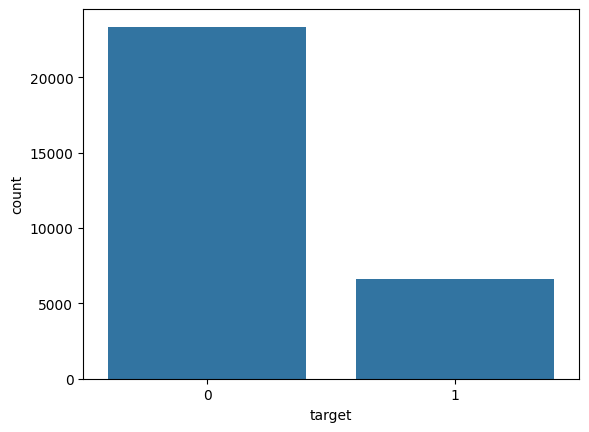

In [179]:
sns.countplot(x = df['target'])

In [180]:
pd.crosstab(index=df['target'], columns='%',normalize=True)*100

col_0,%
target,
0,77.88
1,22.12


**Limite de Crédito**

<Axes: xlabel='limite'>

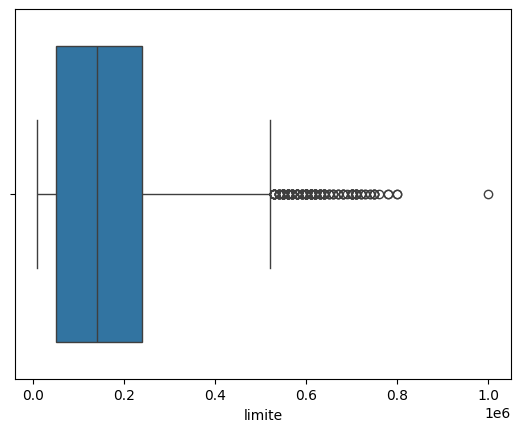

In [181]:
sns.boxplot(df['limite'], orient="h")

In [182]:
df['limite'].describe()

,limite
count,30000.000000
mean,167484.322667
std,129747.661567
min,10000.000000
25%,50000.000000
50%,140000.000000
75%,240000.000000
max,1000000.000000


<Axes: xlabel='limite', ylabel='Count'>

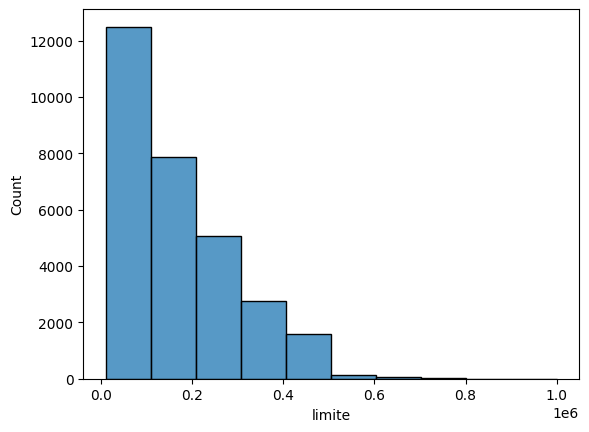

In [183]:
sns.histplot(df['limite'], bins=10)

In [184]:
#assimetria do limite de crédito:
from scipy.stats import skew
skew(df['limite'])

np.float64(0.9928173164820109)

**Idade**

<Axes: xlabel='idade'>

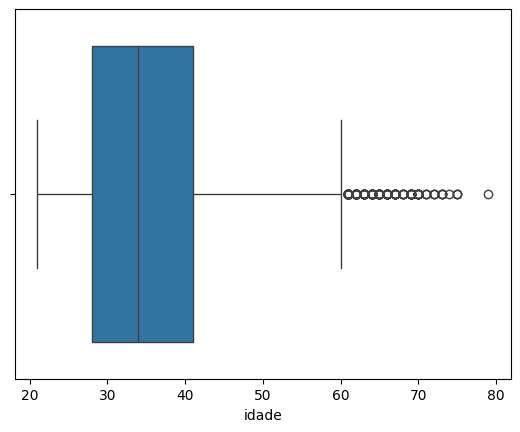

In [185]:
sns.boxplot(df['idade'], orient="h")

In [186]:
df['idade'].describe()

,idade
count,30000.000000
mean,35.485500
std,9.217904
min,21.000000
25%,28.000000
50%,34.000000
75%,41.000000
max,79.000000


<Axes: xlabel='idade', ylabel='Count'>

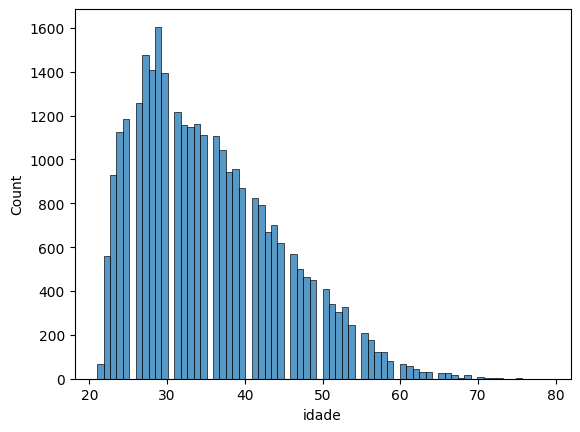

In [187]:
sns.histplot(df['idade'])

In [188]:
#assimetria da idade:
skew(df['idade'], nan_policy ='omit')

np.float64(0.7322092559811012)

**Estado Civil**

1: Casado
2: Solteiro
3: Outros

<Axes: xlabel='estado_civil', ylabel='count'>

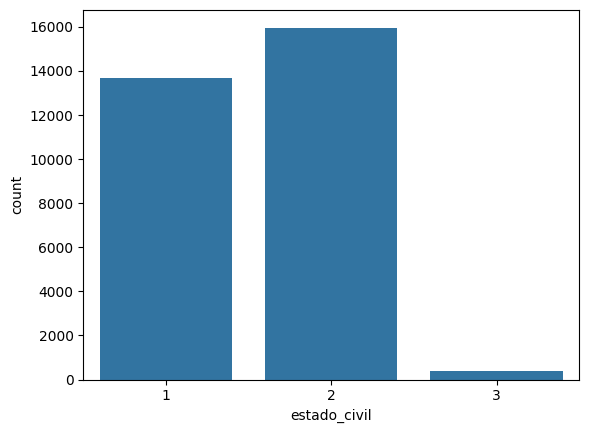

In [189]:
sns.countplot(x = df['estado_civil'])

In [190]:
pd.crosstab(index=df['estado_civil'], columns='%',normalize=True)*100

col_0,%
estado_civil,
1,45.530000
2,53.213333
3,1.256667


**Sexo**

1: Masculino
2: Feminino

<Axes: xlabel='sexo', ylabel='count'>

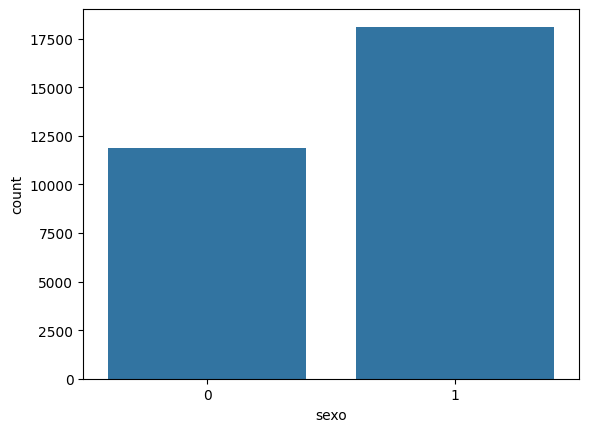

In [191]:
sns.countplot(x = df['sexo'])

In [192]:
pd.crosstab(index=df['sexo'], columns='%',normalize=True)*100

col_0,%
sexo,
0,39.626667
1,60.373333


**Escolaridade**

1: Pós-Gaduação
2: Graduação
3: Ensino Médio
4: Outros

<Axes: xlabel='escolaridade', ylabel='count'>

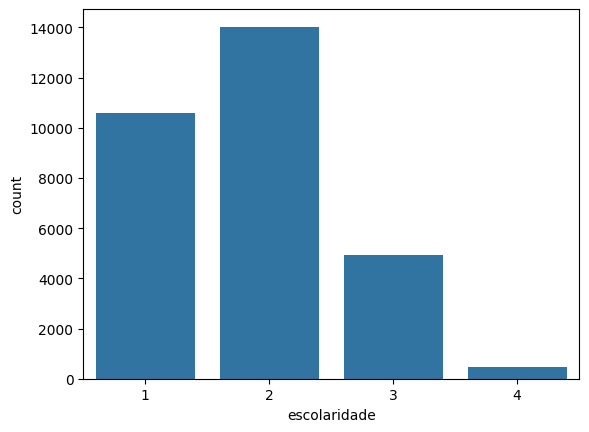

In [193]:
sns.countplot(x = df['escolaridade'])

In [194]:
pd.crosstab(index=df['escolaridade'], columns='%',normalize=True)*100

col_0,%
escolaridade,
1,35.283333
2,46.766667
3,16.390000
4,1.560000


**Valor da Fatura**

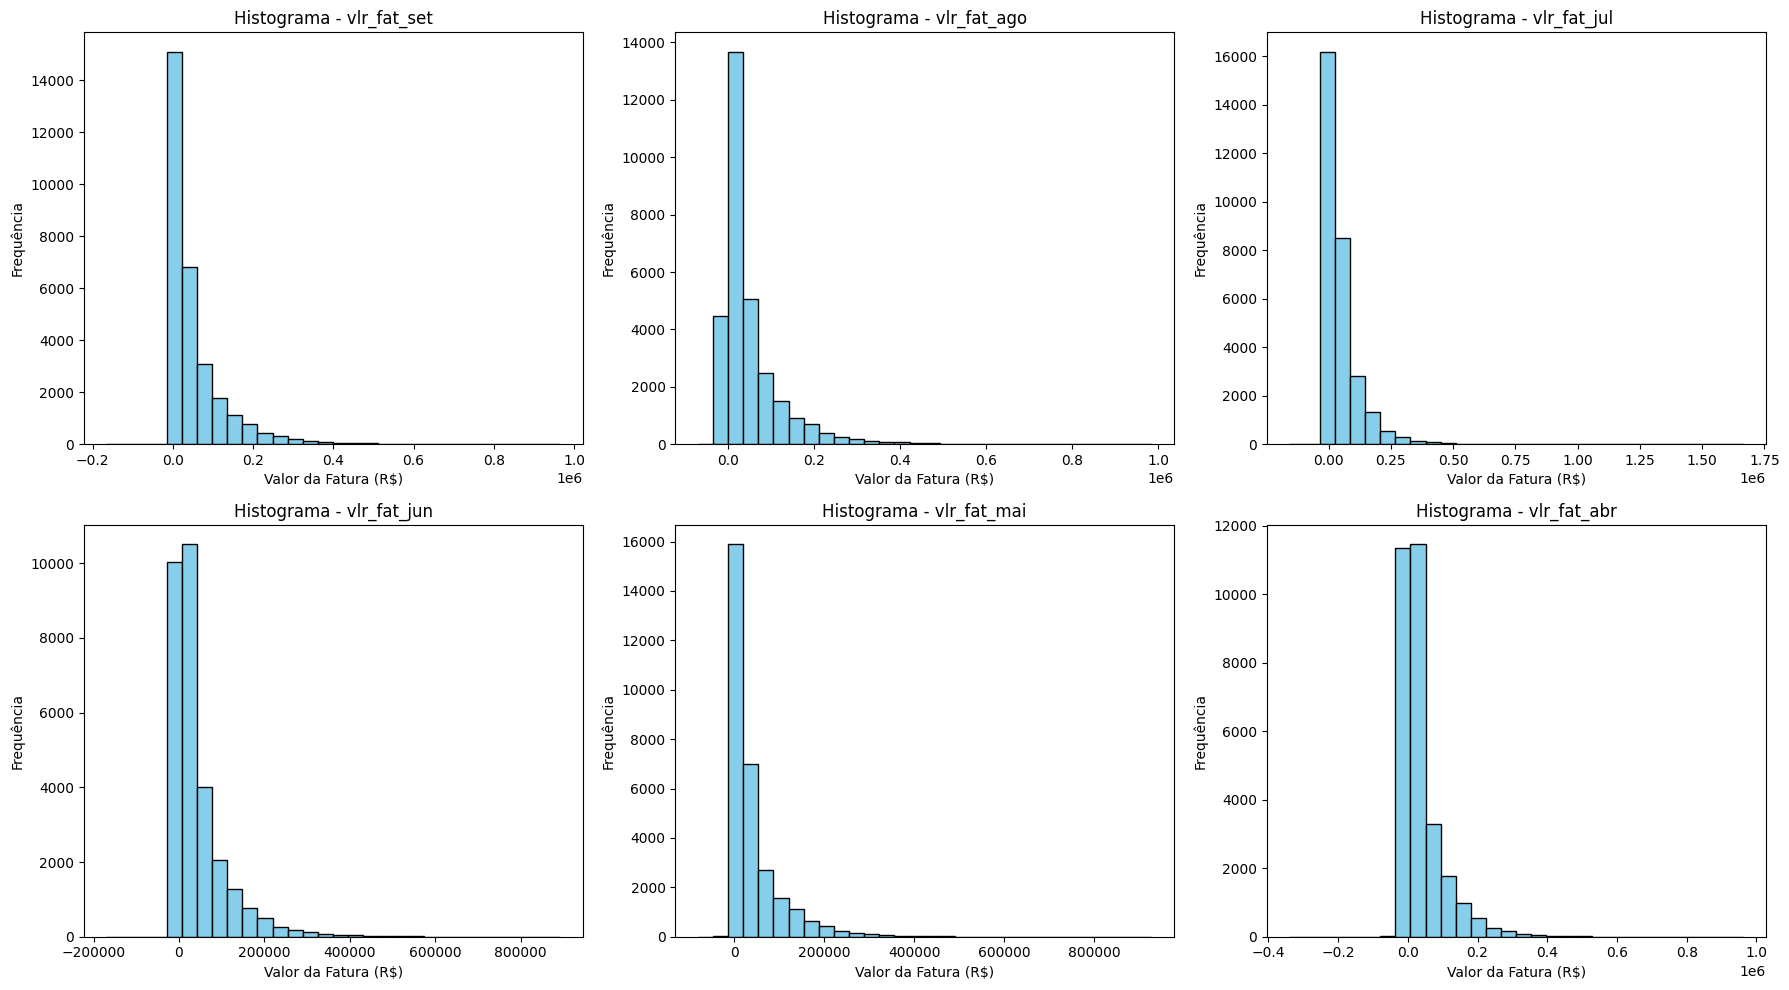

In [195]:
fat_cols = ['vlr_fat_set', 'vlr_fat_ago', 'vlr_fat_jul',
            'vlr_fat_jun', 'vlr_fat_mai', 'vlr_fat_abr']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(fat_cols):
    ax = axes[i]
    ax.hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Histograma - {col}')
    ax.set_xlabel('Valor da Fatura (R$)')
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()


In [196]:
# Estatisticas Valor da Fatura
desc_faturas = df[fat_cols].describe().T
desc_faturas_formatado = desc_faturas.applymap(lambda x: f"{x:,.2f}")

print(desc_faturas_formatado)

                 count       mean        std          min       25%  \
vlr_fat_set  30,000.00  51,223.33  73,635.86  -165,580.00  3,558.75   
vlr_fat_ago  30,000.00  49,179.08  71,173.77   -69,777.00  2,984.75   
vlr_fat_jul  30,000.00  47,013.15  69,349.39  -157,264.00  2,666.25   
vlr_fat_jun  30,000.00  43,262.95  64,332.86  -170,000.00  2,326.75   
vlr_fat_mai  30,000.00  40,311.40  60,797.16   -81,334.00  1,763.00   
vlr_fat_abr  30,000.00  38,871.76  59,554.11  -339,603.00  1,256.00   

                   50%        75%           max  
vlr_fat_set  22,381.50  67,091.00    964,511.00  
vlr_fat_ago  21,200.00  64,006.25    983,931.00  
vlr_fat_jul  20,088.50  60,164.75  1,664,089.00  
vlr_fat_jun  19,052.00  54,506.00    891,586.00  
vlr_fat_mai  18,104.50  50,190.50    927,171.00  
vlr_fat_abr  17,071.00  49,198.25    961,664.00  


In [197]:
fat_cols = ['vlr_fat_set', 'vlr_fat_ago', 'vlr_fat_jul',
            'vlr_fat_jun', 'vlr_fat_mai', 'vlr_fat_abr']

assimetria = {}

for col in fat_cols:
    assimetria[col] = skew(df[col], nan_policy='omit')

for col, val in assimetria.items():
    print(f'Assimetria de {col}: {val:.4f}')


Assimetria de vlr_fat_set: 2.6637
Assimetria de vlr_fat_ago: 2.7051
Assimetria de vlr_fat_jul: 3.0877
Assimetria de vlr_fat_jun: 2.8218
Assimetria de vlr_fat_mai: 2.8762
Assimetria de vlr_fat_abr: 2.8465


**Valor Pago na Fatura**

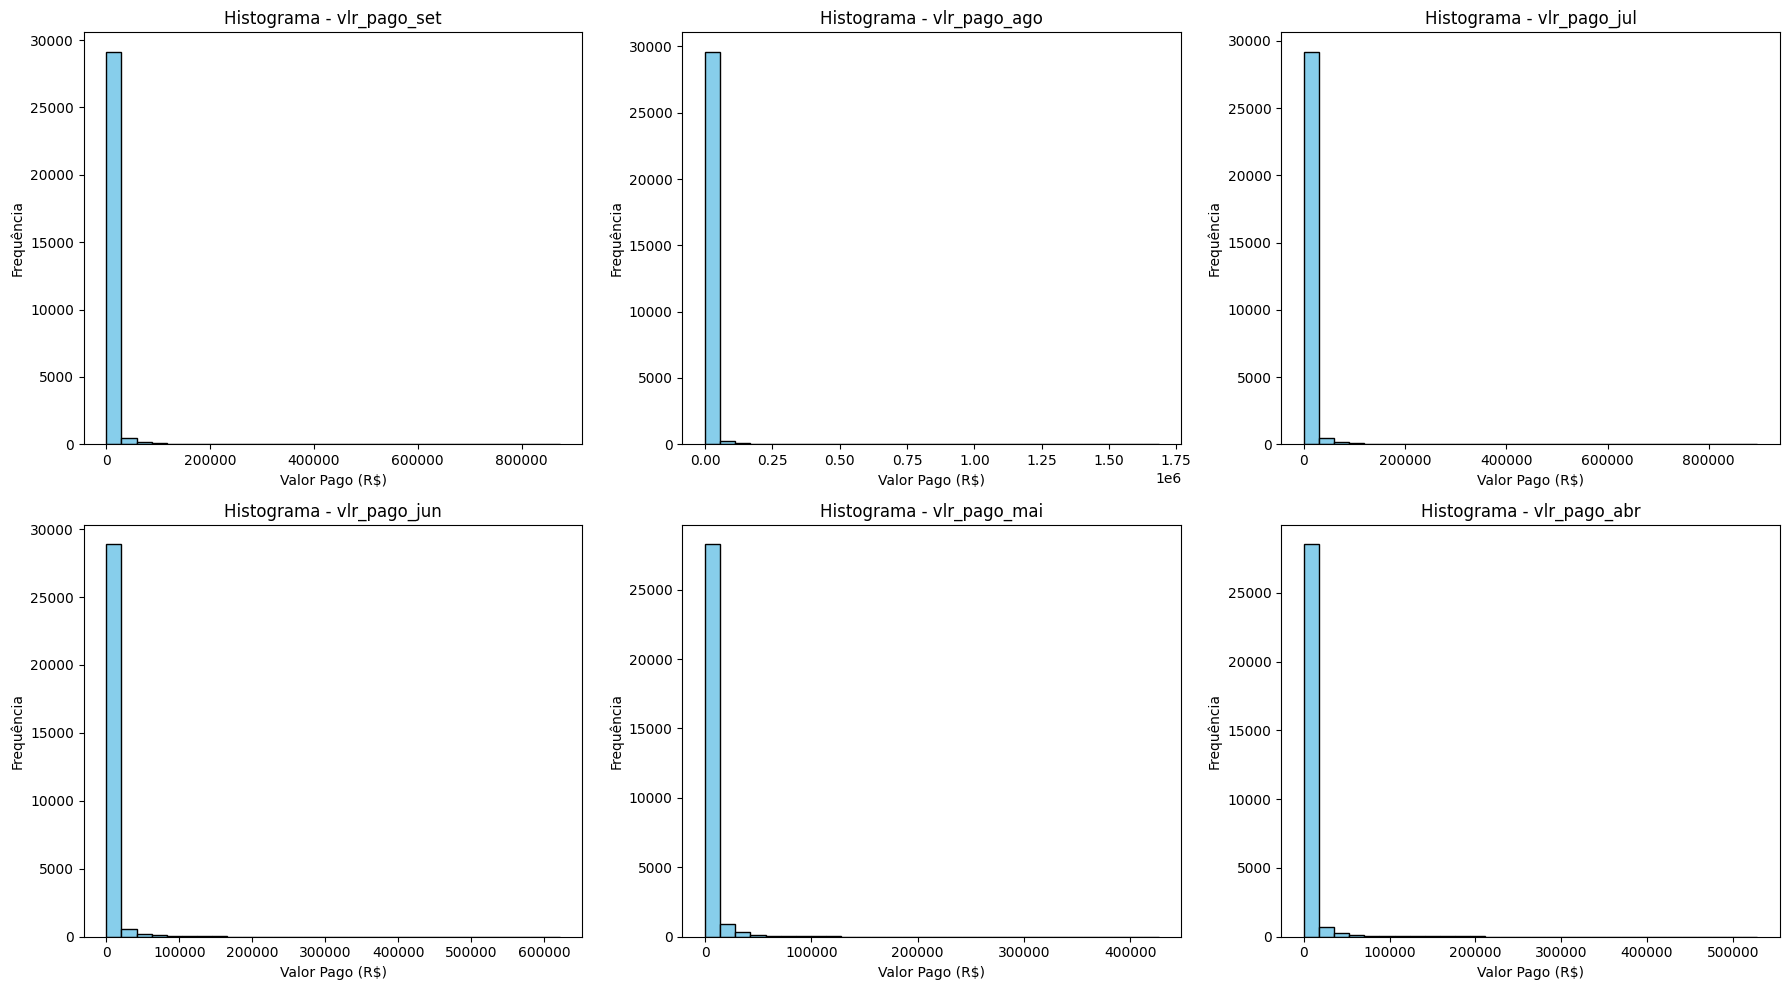

In [198]:
pag_cols = ['vlr_pago_set', 'vlr_pago_ago', 'vlr_pago_jul',
            'vlr_pago_jun', 'vlr_pago_mai', 'vlr_pago_abr']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(pag_cols):
    ax = axes[i]
    ax.hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Histograma - {col}')
    ax.set_xlabel('Valor Pago (R$)')
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [199]:
for col in pag_cols:
    assimetria[col] = skew(df[col], nan_policy='omit')

for col, val in assimetria.items():
    print(f'Assimetria de {col}: {val:.4f}')

Assimetria de vlr_fat_set: 2.6637
Assimetria de vlr_fat_ago: 2.7051
Assimetria de vlr_fat_jul: 3.0877
Assimetria de vlr_fat_jun: 2.8218
Assimetria de vlr_fat_mai: 2.8762
Assimetria de vlr_fat_abr: 2.8465
Assimetria de vlr_pago_set: 14.6676
Assimetria de vlr_pago_ago: 30.4523
Assimetria de vlr_pago_jul: 17.2158
Assimetria de vlr_pago_jun: 12.9043
Assimetria de vlr_pago_mai: 11.1269
Assimetria de vlr_pago_abr: 10.6402


**Situação do Pagamento**

-1: Pagamento Adiantado

0: Pagamento sem Atraso

1: Pagamento com atraso de 1 mes

2: Pagamento com atraso de 2 meses

3: Pagamento com atraso de 3 meses

e assim por diante

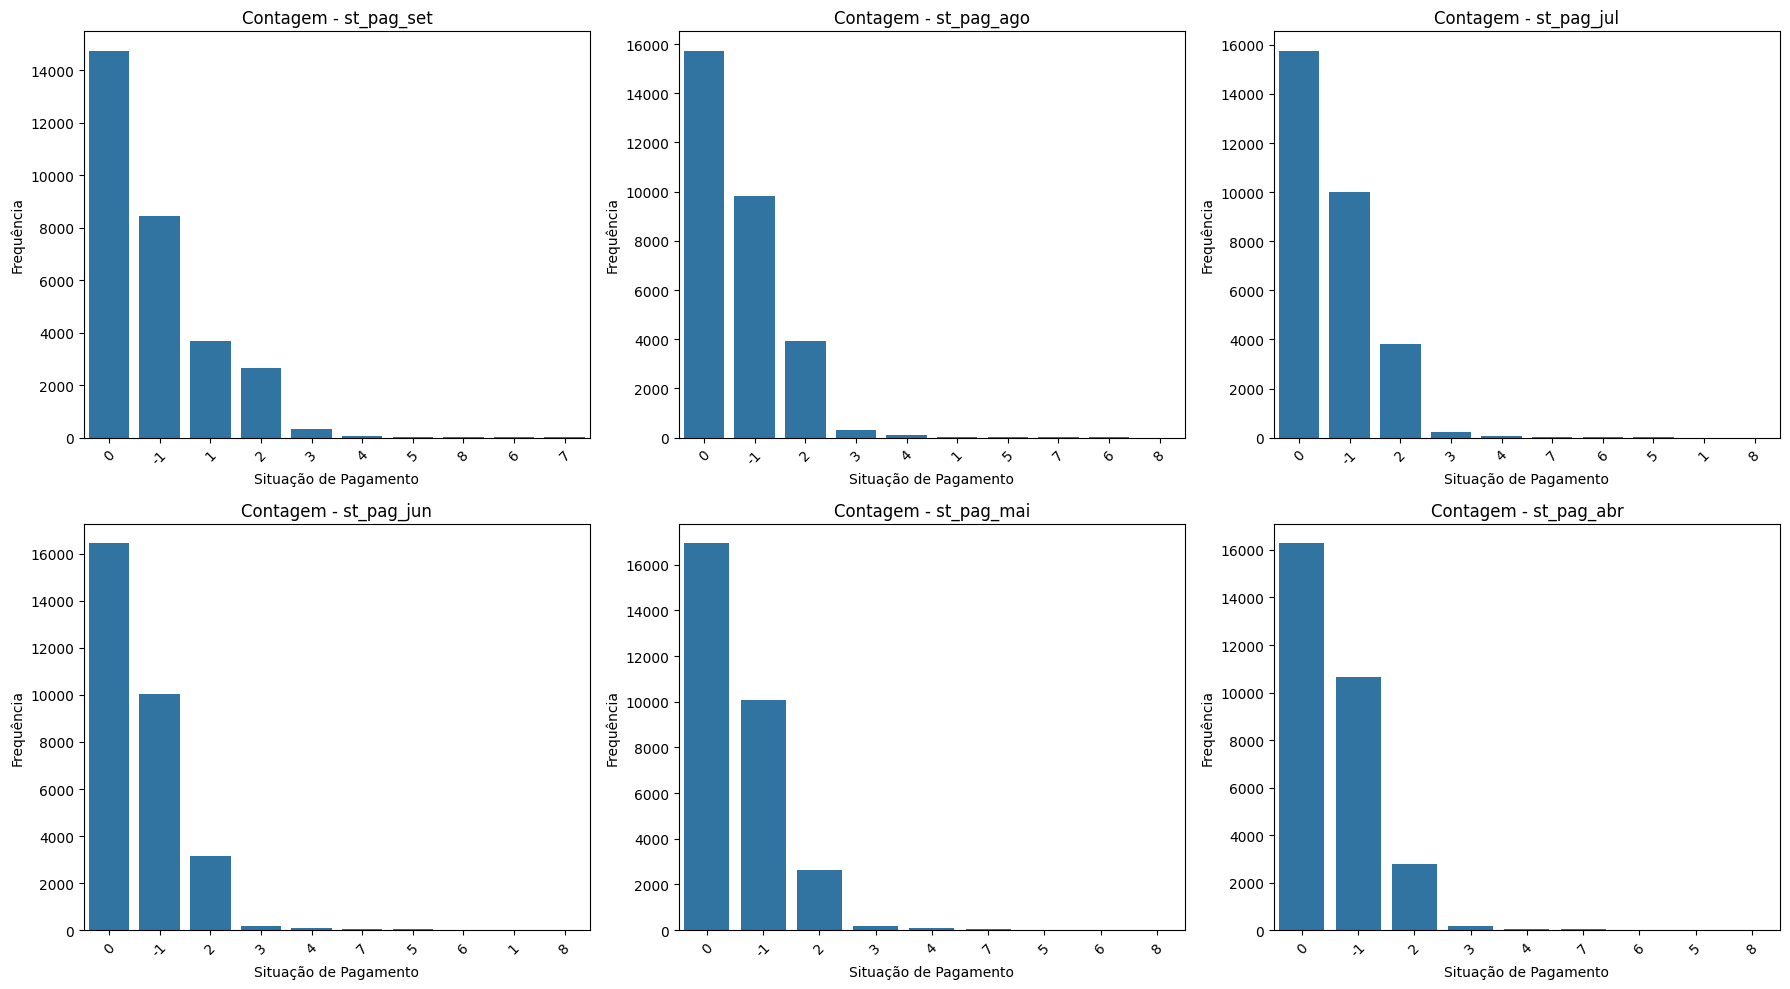

In [200]:
# colunas de situação de pagamento
sit_pag_cols = ['st_pag_set', 'st_pag_ago', 'st_pag_jul', 'st_pag_jun', 'st_pag_mai', 'st_pag_abr']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(sit_pag_cols):
    ax = axes[i]
    sns.countplot(x=df[col], ax=ax, order=df[col].value_counts().index)
    ax.set_title(f'Contagem - {col}')
    ax.set_xlabel('Situação de Pagamento')
    ax.set_ylabel('Frequência')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

In [201]:
sit_pag_cols = ['st_pag_set', 'st_pag_ago', 'st_pag_jul', 'st_pag_jun', 'st_pag_mai', 'st_pag_abr']

resultados = {}

for col in sit_pag_cols:
    pct = df[col].value_counts(normalize=True) * 100
    resultados[col] = pct.round(2)

df_percentual = pd.DataFrame(resultados).fillna(0).sort_index()

df_percentual['média (%)'] = df_percentual.mean(axis=1).round(2)
df_percentual['mediana (%)'] = df_percentual.median(axis=1).round(2)

df_percentual

,st_pag_set,st_pag_ago,st_pag_jul,st_pag_jun,st_pag_mai,st_pag_abr,média (%),mediana (%)
-1,28.15,32.77,33.41,33.45,33.62,35.45,32.81,33.41
0,49.12,52.43,52.55,54.85,56.49,54.29,53.29,53.29
1,12.29,0.09,0.01,0.01,0.00,0.00,2.07,0.01
2,8.89,13.09,12.73,10.53,8.75,9.22,10.54,10.53
3,1.07,1.09,0.80,0.60,0.59,0.61,0.79,0.79
4,0.25,0.33,0.25,0.23,0.28,0.16,0.25,0.25
5,0.09,0.08,0.07,0.12,0.06,0.04,0.08,0.08
6,0.04,0.04,0.08,0.02,0.01,0.06,0.04,0.04
7,0.03,0.07,0.09,0.19,0.19,0.15,0.12,0.12
8,0.06,0.00,0.01,0.01,0.00,0.01,0.01,0.01


**Principais conclusões sobre a análise univariada**:

- Inadimplência de 22%.
- 75% dos clientes têm limite de crédito de até R$ 240 mil.
- A idade varia de 21 a 79 anos, sendo que 75% dos clientes possuem até 41 anos.

- 45% dos clientes são casados, 53% são solteiros e 2% não informaram estado civil.

- 40% dos clientes são homens e 60% são mulheres.

- 47% possuem pós-graduação, 35% graduação, 16% ensino médio e 2% não informaram escolaridade.

- A maioria dos clientes possui faturas que variam de 1.200 a 67 mil, com mediana em torno de 20 mil, mas há casos extremos que ultrapassam 1 milhão.

- 90% dos inadimplentes atrasam de 1 a 2 meses.

- Todas as distribuções das variáveis numéricas são assimétricas.

#**5.2 Análise Bivariada**

Quais são os fatores que influenciam o cliente a se tornar inadimplente: Combinando as variáveis preditoras com a variável (target) alvo

**Relação entre Idade e Target**

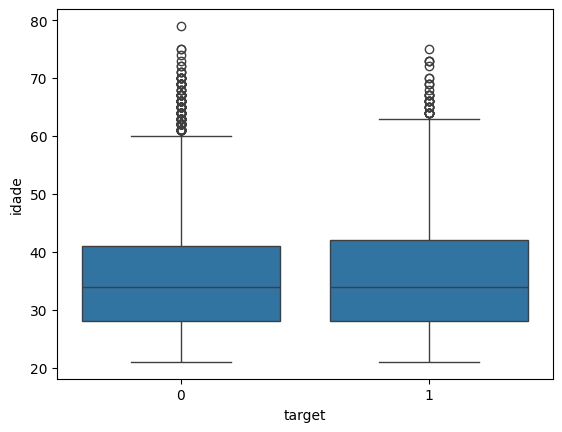

In [202]:
# Boxplot da idade por target
sns.boxplot(x='target', y='idade', data=df)
plt.show()


Notas:

A idade não parece ser um fator discriminante forte para inadimplência nesse conjunto de dados, pois as distribuições são praticamente iguais.

In [203]:
df.groupby('target')['idade'].agg(['mean', 'median'])

,mean,median
target,,
0,35.417266,34.0
1,35.725738,34.0


**Relação entre escolaridade e target**

In [204]:
# Crosstab escolaridade x target
ct = pd.crosstab(df['escolaridade'], df['target'], normalize='index') * 100
print(ct)

target                0          1
escolaridade                      
1             80.765234  19.234766
2             76.265146  23.734854
3             74.842384  25.157616
4             92.948718   7.051282


Notas:

A inadimplência tende a diminuir conforme aumenta o nível de escolaridade, sugerindo que escolaridade mais alta está associada a menor risco de inadimplência.

**Relação entre sexo e target**

In [205]:
tabela = pd.crosstab(index=df['sexo'], columns=df['target'],normalize='index')*100
tabela

target,0,1
sexo,,
0,75.832773,24.167227
1,79.223719,20.776281


Notas:

Clientes do sexo masculino apresentam uma inadimplência maior que os do sexo feminino.

**Relação entre Limite de Crédito e target**

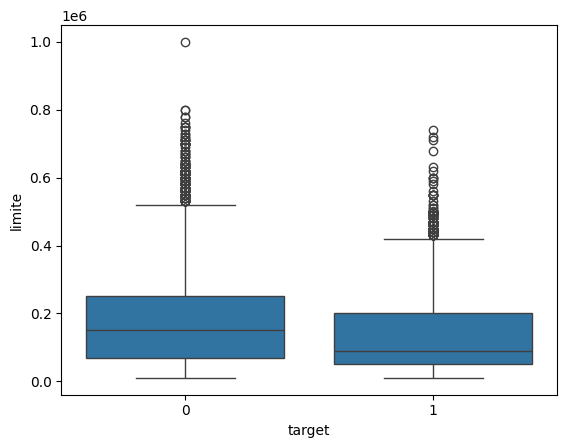

In [206]:
# Boxplot da idade por target
sns.boxplot(x='target', y='limite', data=df)
plt.show()


In [207]:
df.groupby('target')['limite'].agg(['mean', 'median'])

,mean,median
target,,
0,178099.726074,150000.0
1,130109.656420,90000.0


Notas:

Clientes inadimplentes possuem, em média, limites de crédito significativamente menores do que os adimplentes (cerca de 48 mil a menos na média e 60 mil na mediana).

Isso sugere que clientes com limites mais baixos são proporcionalmente mais propensos à inadimplência. Pode indicar:

- Que baixo limite é reflexo de um perfil de maior risco;

- Ou que clientes com menor capacidade financeira estão mais vulneráveis a atrasos, mesmo com limites menores.

**Correlação entre as variáveis**


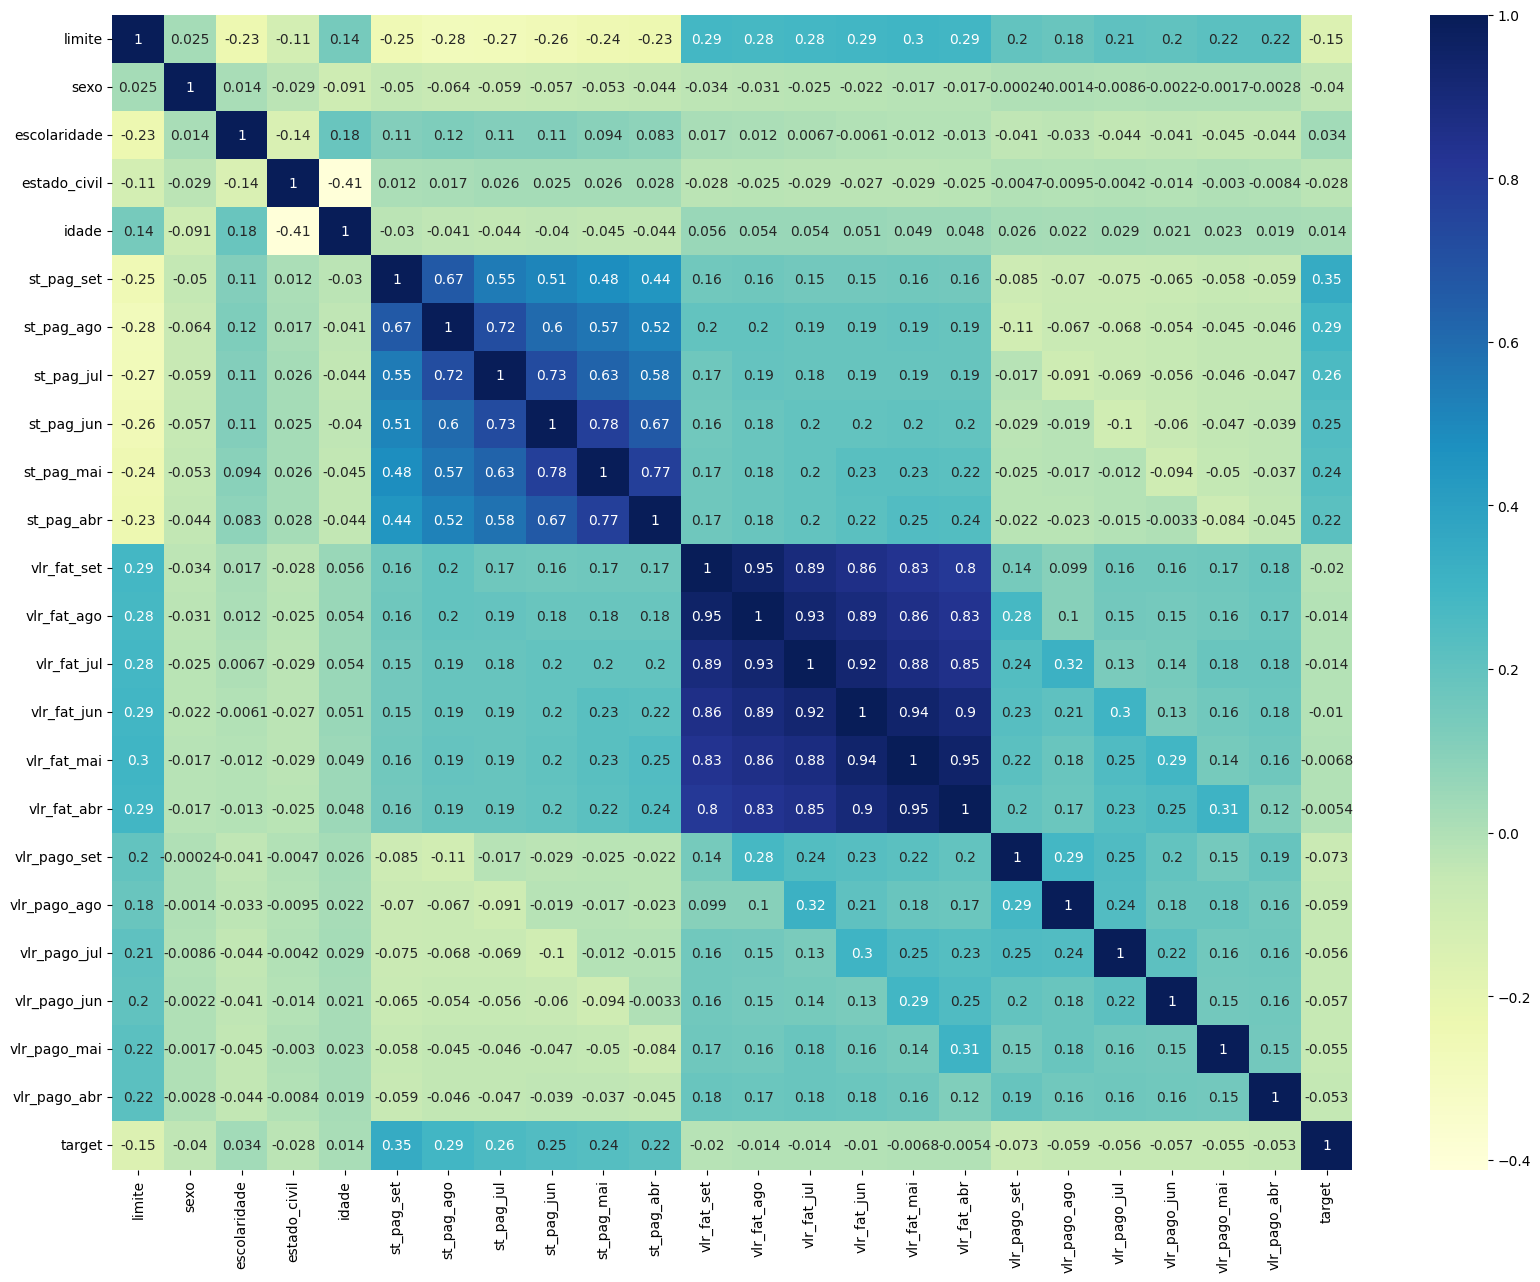

In [208]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu");

Notas:

- Variáveis como **vlr_fat_set, vlr_fat_ago, vlr_fat_jul, etc**., estão fortemente correlacionadas entre si, indicando que os valores das faturas mensais são consistentes e crescem ou caem juntos.

- As variáveis **st_pag_set, st_pag_ago, etc**., também apresentam correlações moderadas a fortes entre si, mostrando que o status de pagamento de meses próximos tende a se relacionar.

- A variável **target** tem correlação positiva moderada com variáveis como **st_pag_set** (0.32), sugerindo que atrasos nos pagamentos estão ligados à inadimplência.

- Algumas variáveis como **sexo, escolaridade e estado_civil** têm correlações muito baixas com outras variáveis e com o target, indicando que esses fatores têm pouco impacto linear no resultado.

In [209]:
mapa_inverso = {1: 4, 2: 3, 3: 2, 4: 1}
df['escolaridade'] = df['escolaridade'].map(mapa_inverso)

Notas:

O mapeamento foi feito para corrigir a ordem da variável escolaridade, que estava invertida na base original. Agora, a ordem correta reflete o nível educacional crescente:
1 = Outros, 2 = Ensino Médio, 3 = Graduação, 4 = Pós-graduação. Isso garante uma análise mais coerente com a realidade.

#**6. Desenvolvimento do Modelo (Regressão Logística)**

In [210]:
# Criar dummies para as colunas estado civil e escolaridade
X = pd.get_dummies(df, columns=['estado_civil', 'escolaridade'], drop_first=True)

# Separar variável resposta
y = df['target']

if 'target' in X.columns:
    X.drop(columns=['target'], inplace=True)

X.head(5)

,limite,sexo,idade,st_pag_set,st_pag_ago,st_pag_jul,st_pag_jun,st_pag_mai,st_pag_abr,vlr_fat_set,...,vlr_pago_ago,vlr_pago_jul,vlr_pago_jun,vlr_pago_mai,vlr_pago_abr,estado_civil_2,estado_civil_3,escolaridade_3,escolaridade_2,escolaridade_1
0,20000,1,24,2,2,-1,-1,-1,-1,3913,...,689,0,0,0,0,False,False,True,False,False
1,120000,1,26,-1,2,0,0,0,2,2682,...,1000,1000,1000,0,2000,True,False,True,False,False
2,90000,1,34,0,0,0,0,0,0,29239,...,1500,1000,1000,1000,5000,True,False,True,False,False
3,50000,1,37,0,0,0,0,0,0,46990,...,2019,1200,1100,1069,1000,False,False,True,False,False
4,50000,0,57,-1,0,-1,0,0,0,8617,...,36681,10000,9000,689,679,False,False,True,False,False


Notas:

Usei drop_first=True para evitar multicolinearidade perfeita entre as variáveis dummies, que pode prejudicar modelos lineares.
Isso remove uma categoria de cada variável, servindo como referência (categoria base).
Assim, o modelo não fica com informações redundantes e aprende corretamente os efeitos das categorias.

In [211]:
cols_to_scale = ['limite','idade',
                 'vlr_fat_set','vlr_fat_ago','vlr_fat_jul','vlr_fat_jun','vlr_fat_mai','vlr_fat_abr',
                 'vlr_pago_set','vlr_pago_ago','vlr_pago_jul','vlr_pago_jun','vlr_pago_mai','vlr_pago_abr']

scaler = StandardScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

X.head()

,limite,sexo,idade,st_pag_set,st_pag_ago,st_pag_jul,st_pag_jun,st_pag_mai,st_pag_abr,vlr_fat_set,...,vlr_pago_ago,vlr_pago_jul,vlr_pago_jun,vlr_pago_mai,vlr_pago_abr,estado_civil_2,estado_civil_3,escolaridade_3,escolaridade_2,escolaridade_1
0,-1.136720,1,-1.246020,2,2,-1,-1,-1,-1,-0.642501,...,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,False,False,True,False,False
1,-0.365981,1,-1.029047,-1,2,0,0,0,2,-0.659219,...,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,True,False,True,False,False
2,-0.597202,1,-0.161156,0,0,0,0,0,0,-0.298560,...,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,True,False,True,False,False
3,-0.905498,1,0.164303,0,0,0,0,0,0,-0.057491,...,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,False,False,True,False,False
4,-0.905498,0,2.334029,-1,0,-1,0,0,0,-0.578618,...,1.335034,0.271165,0.266434,-0.269039,-0.255187,False,False,True,False,False


Notas:

Padronizei para colocar as variáveis numéricas em uma mesma escala, com média zero e desvio padrão um.
Isso evita que variáveis com valores maiores dominem o modelo, melhorando a performance.
Escolhi padronização ao invés de normalização porque ela é mais indicada para modelos como regressão logística, que se beneficiam de dados com distribuição centrada e variância uniforme.

In [212]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Notas:

Foi realizada a divisão da base de dados em 70% para treinamento e 30% para teste, utilizando estratificação pela variável alvo para manter a proporção entre adimplentes e inadimplentes nos dois conjuntos.

In [213]:
X_train.head()

,limite,sexo,idade,st_pag_set,st_pag_ago,st_pag_jul,st_pag_jun,st_pag_mai,st_pag_abr,vlr_fat_set,...,vlr_pago_ago,vlr_pago_jul,vlr_pago_jun,vlr_pago_mai,vlr_pago_abr,estado_civil_2,estado_civil_3,escolaridade_3,escolaridade_2,escolaridade_1
11018,-0.057685,1,-0.378129,0,0,0,0,0,0,1.424257,...,0.003422,0.021260,0.074935,0.078584,0.016004,True,False,True,False,False
1710,-0.520128,1,-0.595102,0,0,0,0,2,0,-0.310185,...,0.177029,0.271165,-0.308063,-0.127856,-0.184478,True,False,False,False,False
4618,-0.674276,0,-0.703588,0,0,0,0,0,0,0.305545,...,-0.148485,-0.208426,-0.205930,-0.209411,-0.203379,True,False,False,False,False
5482,-1.136720,1,-0.920561,0,0,-1,-1,-1,-1,-0.596694,...,-0.223136,-0.296801,-0.308063,-0.314136,-0.293382,False,False,True,False,False
26187,-0.905498,1,-0.595102,-1,-1,-1,-1,-1,-1,-0.695642,...,-0.256990,-0.296801,-0.308063,-0.314136,-0.293382,True,False,False,False,False


In [214]:
X_test.head()

,limite,sexo,idade,st_pag_set,st_pag_ago,st_pag_jul,st_pag_jun,st_pag_mai,st_pag_abr,vlr_fat_set,...,vlr_pago_ago,vlr_pago_jul,vlr_pago_jun,vlr_pago_mai,vlr_pago_abr,estado_civil_2,estado_civil_3,escolaridade_3,escolaridade_2,escolaridade_1
8941,0.481833,0,-0.595102,0,0,0,0,0,0,0.687294,...,-0.083382,-0.181561,-0.180397,-0.150503,-0.220255,True,False,True,False,False
17618,-0.674276,1,-0.378129,-1,3,2,-1,0,0,-0.628730,...,-0.256990,-0.021678,-0.308063,-0.314136,-0.293382,False,False,False,False,False
27895,-0.520128,1,-0.703588,0,0,0,0,0,0,1.577881,...,-0.093408,-0.182754,-0.183588,-0.183164,0.719153,True,False,False,False,False
16103,-1.213794,1,0.164303,-1,4,3,2,2,2,-0.650758,...,-0.256990,-0.268403,-0.282529,-0.314136,-0.291357,False,False,True,False,False
4422,-0.443054,1,-0.161156,0,0,0,0,0,0,-0.367712,...,-0.170186,-0.211606,0.011102,0.104765,-0.293382,False,False,True,False,False


In [215]:
cols_bool = ['estado_civil_2','estado_civil_3','escolaridade_1','escolaridade_2','escolaridade_3']
X_train[cols_bool] = X_train[cols_bool].astype(int)
X_test[cols_bool] = X_test[cols_bool].astype(int)

In [216]:
# Criação do modelo
model = LogisticRegression(max_iter=1000, random_state=42)

# Treino do modelo com os dados de treino
model.fit(X_train, y_train)

# previsões no conjunto de teste
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

Acurácia: 0.8094444444444444
Matriz de Confusão:
 [[6759  250]
 [1465  526]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.96      0.89      7009
           1       0.68      0.26      0.38      1991

    accuracy                           0.81      9000
   macro avg       0.75      0.61      0.63      9000
weighted avg       0.79      0.81      0.78      9000

AUC-ROC: 0.7198181874076087


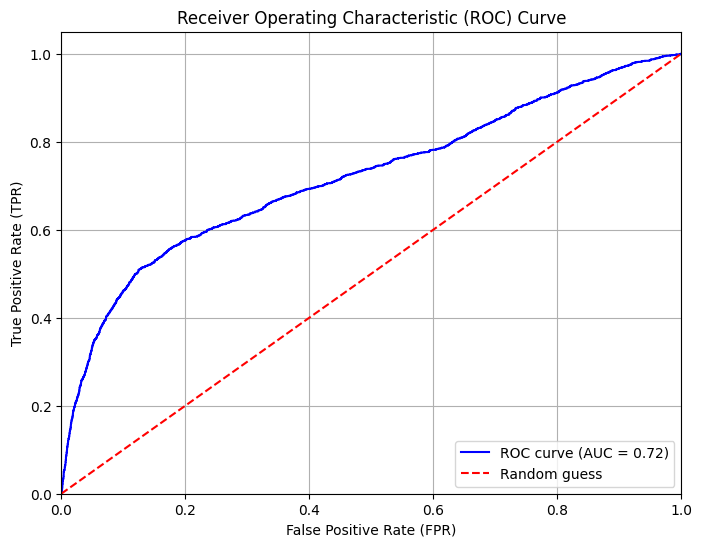

In [217]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [218]:
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print(f'Melhor limiar pelo Youden J: {best_threshold:.3f}')

Melhor limiar pelo Youden J: 0.272


In [219]:
y_probs = model.predict_proba(X_test)[:, 1]
threshold = 0.272
y_pred_custom = np.where(y_probs > threshold, 1, 0)

In [220]:
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))
auc = roc_auc_score(y_test, y_probs)
print(f"AUC-ROC: {auc:.4f}")

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      7009
           1       0.53      0.51      0.52      1991

    accuracy                           0.79      9000
   macro avg       0.70      0.69      0.70      9000
weighted avg       0.79      0.79      0.79      9000

[[6122  887]
 [ 974 1017]]
AUC-ROC: 0.7198


Notas:

- O modelo apresentou boa acurácia (0.79) e AUC-ROC de 0.72, indicando desempenho razoável na distinção entre adimplentes e inadimplentes.

- Adimplentes (classe 0): modelo teve alta performance (precision e recall de 0.86 e 0.87).

- Inadimplentes (classe 1): desempenho moderado (precision e recall de 0.53 e 0.51), indicando que ainda há muitos inadimplentes não identificados.

- Conclusão: o modelo identifica bem os bons pagadores, mas precisa melhorar a detecção dos inadimplentes, essencial para aplicações de risco de crédito.

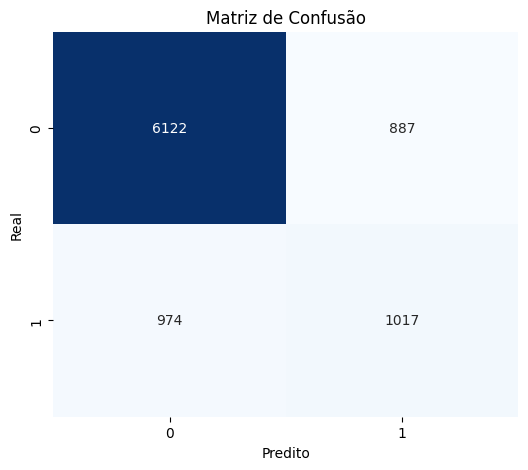

In [221]:
cm = confusion_matrix(y_test, y_pred_custom)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

**Resumo estatístico completo do modelo**

In [222]:
# Adicionar constante (intercepto)
X_train_sm = sm.add_constant(X_train)

# Ajustar o modelo
model_sm = sm.Logit(y_train, X_train_sm)
result = model_sm.fit()

# Mostrar resumo completo
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.456772
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                21000
Model:                          Logit   Df Residuals:                    20973
Method:                           MLE   Df Model:                           26
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                  0.1356
Time:                        19:31:05   Log-Likelihood:                -9592.2
converged:                       True   LL-Null:                       -11097.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.2078      0.048    -25.299      0.000      -1.301      -1.114
limite           

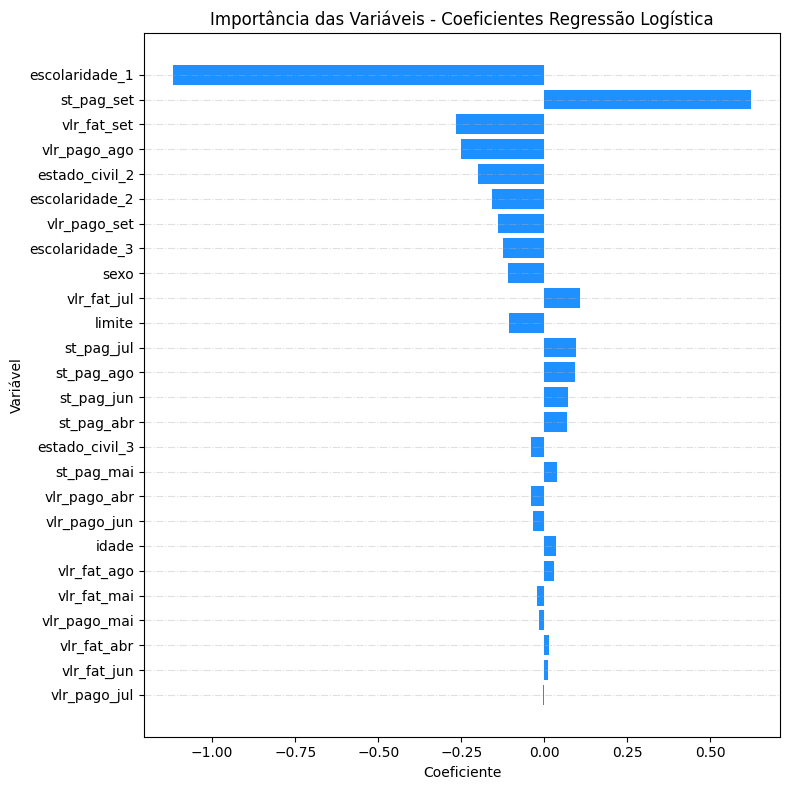

In [223]:
# coeficientes do modelo
coef_lr = pd.DataFrame({
    'var': X_test.columns,
    'coef': model.coef_.flatten()
})

index_sort = np.abs(coef_lr['coef']).sort_values().index
coef_lr_sort = coef_lr.loc[index_sort, :]

fig, ax = plt.subplots(figsize=(8,8))
x = coef_lr_sort['var']
y = coef_lr_sort['coef']
rects = plt.barh(x, y, color='dodgerblue')
plt.grid(linestyle='-.', axis='y', alpha=0.4)
plt.title('Importância das Variáveis - Coeficientes Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()

In [224]:
coef = result.params  # coeficientes
conf = result.conf_int()  # intervalo de confiança
conf.columns = ['2.5%', '97.5%']

# Calcular Odds Ratios
odds_ratios = np.exp(coef)
conf_odds = np.exp(conf)

df_or = pd.DataFrame({
    'Coeficiente': coef,
    'Odds Ratio': odds_ratios,
    'IC 2.5%': conf_odds['2.5%'],
    'IC 97.5%': conf_odds['97.5%'],
    'Percentual de mudança (%)': (odds_ratios - 1) * 100
})

df_or

,Coeficiente,Odds Ratio,IC 2.5%,IC 97.5%,Percentual de mudança (%)
const,-1.207841,0.298842,0.272147,0.328155,-70.115818
limite,-0.107386,0.898179,0.855963,0.942476,-10.182136
sexo,-0.109681,0.896120,0.833125,0.963878,-10.388015
idade,0.034713,1.035322,0.993814,1.078564,3.532230
st_pag_set,0.623855,1.866107,1.783135,1.952941,86.610725
st_pag_ago,0.091867,1.096219,1.041267,1.154072,9.621930
st_pag_jul,0.094338,1.098931,1.039116,1.162188,9.893080
st_pag_jun,0.071101,1.073690,1.009068,1.142450,7.368978
st_pag_mai,0.039883,1.040689,0.972763,1.113360,4.068944
st_pag_abr,0.068973,1.071407,1.012097,1.134193,7.140698


## **Principais Insights**
- **Atrasos recentes são o maior fator de risco**

  O atraso no pagamento da fatura de setembro aumenta em 86,6% a chance do cliente se tornar inadimplente. Atrasos em meses anteriores também elevam o risco, embora em menor grau (7% a 10%).

- **Educação superior reduz significativamente o risco**

  Clientes com pós-graduação apresentam uma redução de 69,3% na chance de inadimplência em comparação aos clientes com menor escolaridade. Isso indica maior capacidade ou disciplina financeira nesses grupos.

- **Estado civil influencia o comportamento financeiro**

  Clientes solteiros têm risco 17,9% menor que clientes casados. Essa informação pode ser relevante para segmentação e avaliação de perfil de risco.

- **Comportamento de pagamento recente é crucial**

  Quanto maior o valor pago em agosto, menor o risco (redução de 22,3% no risco de inadimplência). Esse comportamento confirma a importância do acompanhamento dos pagamentos recentes.

- **Mulheres apresentam menor risco que homens**

  O risco de inadimplência entre mulheres é 10,4% menor que entre homens, o que pode orientar campanhas e políticas diferenciadas.

- **Faturamento alto associado a menor risco**

  Clientes com faturamento maior em setembro apresentam redução de 23,2% no risco de inadimplência, indicando que faturamento elevado aliado a bons pagamentos é um forte indicador de bom pagador.

## **Recomendações**

- Priorizar o monitoramento dos atrasos recentes, com foco especial em clientes com pagamentos atrasados em setembro.

- Usar escolaridade e estado civil como variáveis para segmentar clientes e ajustar políticas de crédito.

- Dar atenção especial ao comportamento recente de pagamento para decisões mais precisas sobre risco.

- Considerar diferenciação de políticas e comunicação para homens e mulheres, aproveitando o menor risco feminino.

- Explorar estratégias específicas para clientes com faturamento alto e bom histórico de pagamento, valorizando-os para fidelização.


## **Dilema: Prever Inadimplentes x Recusar Bons Pagadores**

Ao prever inadimplência, é preciso equilibrar dois riscos:

- Recusar bons pagadores (perda de receita)

- Aprovar inadimplentes (prejuízo financeiro)

Com base nisso, calculei o custo de cada tipo de erro para diferentes limiares de decisão e escolhi aquele que minimizasse o custo total, considerando os dois lados do dilema.



- Metodologia de Custo-Benefício

Foi Calculado o custo de dois erros: recusar um bom cliente (falso positivo) e aprovar um inadimplente (falso negativo). Para o custo de recusar, foi utilizado o limite de crédito médio como proxy do valor financeiro perdido, multiplicado por uma margem de lucro estimada. O limiar do modelo foi variado até o pnto onde se minimizasse o custo total esperado, buscando o melhor equilíbrio entre risco e retorno.

- Por que usar o limite de crédito?

O limite de crédito é usado como proxy porque representa o valor máximo que o cliente pode usar, refletindo o potencial financeiro envolvido na decisão de concessão.

In [225]:
# Filtra os clientes adimplentes (classe 0)
adimplentes = df[df['target'] == 0]

# Estima o limite médio desses clientes
limite_medio = adimplentes['limite'].mean()

# Supõe uma margem de lucro (ajustável conforme realidade do negócio)
margem_lucro = 0.1  # 10%

# Calcula o custo de oportunidade de recusar um bom cliente
custo_fp = limite_medio * margem_lucro
print(f"Custo estimado de recusar um bom pagador: R$ {custo_fp:.2f}")

Custo estimado de recusar um bom pagador: R$ 17809.97


In [226]:
# Filtra os clientes inadimplentes (classe 1)
inadimplentes = df[df['target'] == 1]

# Estima o limite médio desses clientes (potencial valor perdido)
limite_medio_inadimplentes = inadimplentes['limite'].mean()

# Supõe uma taxa de perda sobre o limite concedido (ajustável conforme negócio)
taxa_perda = 0.7  # perda de 70% do limite concedido

# Calcula o custo médio de aprovar um inadimplente
custo_fn = limite_medio_inadimplentes * taxa_perda
print(f"Custo médio de aprovar um inadimplente (FN): R$ {custo_fn:.2f}")

Custo médio de aprovar um inadimplente (FN): R$ 91076.76


In [227]:
#limiar desejado
threshold = 0.27
y_pred = (y_prob >= threshold).astype(int)

# Matriz de confusão
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Custos estimados
#custo_fp = 17809.97
#custo_fn = 45752.83

# Custo total
custo_total = fp * custo_fp + fn * custo_fn
print(f"Custo total estimado para limiar {threshold}: R$ {custo_total:,.2f}")


Custo total estimado para limiar 0.27: R$ 104,553,558.68


## **Análise de Custo Benefício**

In [228]:
thresholds = np.arange(0.01, 1.0, 0.01)
custos = []

for thresh in thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    custo = fp * custo_fp + fn * custo_fn
    custos.append(custo)


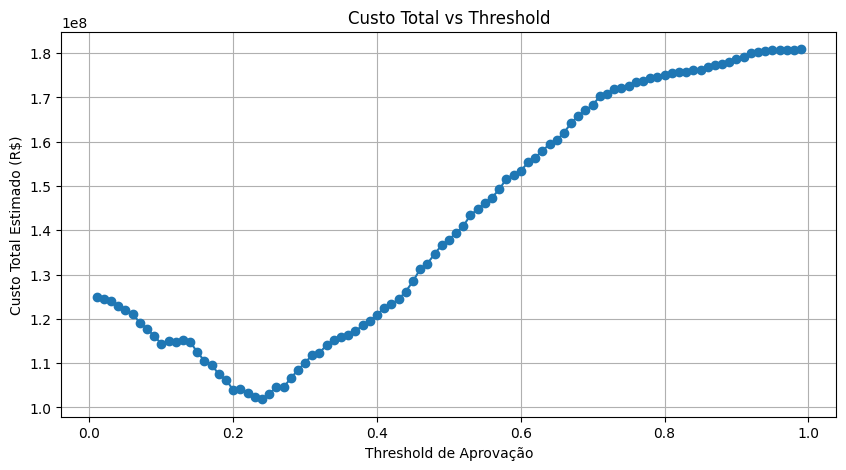

In [229]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, custos, marker='o')
plt.title('Custo Total vs Threshold')
plt.xlabel('Threshold de Aprovação')
plt.ylabel('Custo Total Estimado (R$)')
plt.grid(True)
plt.show()

In [230]:
melhor_threshold = thresholds[np.argmin(custos)]
menor_custo = min(custos)
print(f"Melhor threshold: {melhor_threshold:.2f}")
print(f"Menor custo estimado: R$ {menor_custo:,.2f}")

Melhor threshold: 0.24
Menor custo estimado: R$ 101,854,581.78


Notas:

Melhor threshold: 0,24 (24%).
Este é o ponto de corte ótimo na probabilidade prevista de inadimplência usado para decidir se um cliente deve ser classificado como inadimplente (probabilidade > 24%) ou bom pagador (probabilidade ≤ 24%).

Menor custo estimado: R$ 101.854.578,23
Ao adotar esse threshold, minimizamos o custo financeiro total previsto, que considera:

- Custo de aprovar um cliente inadimplente (falso negativo): perdas financeiras diretas devido a calotes;

- Custo de recusar um bom pagador (falso positivo): perda de receita ao deixar de conceder crédito para clientes que pagariam corretamente.

**Conclusão:** O threshold 0,24 representa um equilíbrio entre evitar perdas financeiras por inadimplência e não restringir demais a concessão de crédito a bons clientes. Adotar esse ponto de corte ajuda a empresa a gerenciar melhor o risco de crédito, otimizando os ganhos financeiros.